In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as func

In [4]:
#For reproducibility
torch.manual_seed(1)

## Softmax
입력받은 값을 출력으로 0~1사이의 값으로 모두 정규화하며 출력 값들의 총합은 항상 1이 되는 특성을 가진 함수

$$P(class=i) = \frac{e^i}{\sum{e^i}}$$

In [5]:
z = torch.FloatTensor([1, 2, 3])

pytorch는 softmax function을 가진다

In [7]:
hypothesis = func.softmax(z, dim=0)
print(hypothesis)

tensor([0.0900, 0.2447, 0.6652])


확률이기 때문에, softmax를 나온 결과를 다 더하면 1이다!

In [8]:
hypothesis.sum()

tensor(1.)

## Cross Entropy Loss (Low-level)

multi-class classification에 대해서, cross entropy loss를 사용하자!

$$ L=\frac{1}{N}\sum{-ylog(\hat{y})}$$

$\hat{y}$는 예측된 확률이고, y는 정답 확률이다. 0 또는 1

pi 가 특정 확률에 대한 참값 또는 목표 확률이고, qi가 우리가 현재 학습한 확률값입니다. 예를 들어 여기서는 **y=[0.5, 0.125, 0.125, 0.25]** 이고, **$\hat{y}$=[0.25, 0.25, 0.25, 0.25]** 가 되는 셈입니다. 따라서, 우리가 어떤 $\hat{y}$ 를 학습하고 있는 상태라면 y에 가까워질수록 cross entropy 값은 작아지게 됩니다.

**torch.rand(3,5)**  
normal distribution에 따라 random변수를 3행 5열의 2D로 받음

In [10]:
z = torch.rand(3, 5, requires_grad=True) # normal distribution에 따라 
hypothesis = func.softmax(z, dim =1)
print(hypothesis)

tensor([[0.1664, 0.1871, 0.1737, 0.2695, 0.2033],
        [0.2002, 0.1783, 0.2218, 0.1944, 0.2054],
        [0.1809, 0.2380, 0.2318, 0.1084, 0.2409]], grad_fn=<SoftmaxBackward>)


**torch.randint(5, (3, ))** = **torch.randint(범위, tensor size)**  
0부터 4까지의 random한 정수를 뽑아서 3 vector로 생성

In [53]:
y = torch.randint(5, (3, )).long() # 0 ~ 4까지의 정수형태의 값을 random하게 뽑아
print(y)

tensor([0, 4, 3])


a = torch.Size([2, 3, 3])일 때,  
**torch.unsqueeze(a, 0)** a의 가로로 차원을 늘림  [[2, 3, 3]]  
**torch.unsqueeze(a, 1)** a의 세로로 차원을 늘림  
[[2],  
 [3],  
 [3]])  
**example)**  
torch.unsqueeze(a,0) --> [1, 2, 3, 3]

In [63]:
y_one_hot = torch.zeros_like(hypothesis) # hypothesis size = [3, 5]
print(y_one_hot)
print(y.unsqueeze(1))
y_one_hot.scatter_(1, y.unsqueeze(1), 1)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
tensor([[0],
        [4],
        [3]])


tensor([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.]])

**torch.scatter_(1, y.unsqueeze(1), 1) = torch.scatter_(dim, index, src)**  
dim0은 아래방향, dim =1은 오른쪽방향  
index = y.unsqueeze(1)  
src = index자리에 1로 바꿔치기 하고싶은 것

In [72]:
cost = (y_one_hot * -torch.log(hypothesis)).sum(dim=1).mean()
print(cost)

tensor(1.8661, grad_fn=<MeanBackward0>)


## Cross-entropy Loss with torch.nn.functional

$$ L=\frac{1}{N}\sum{-ylog(\hat{y})}$$

In [76]:
z = torch.rand(3, 5, requires_grad=True)

In [77]:
# Low level
torch.log(func.softmax(z, dim=0))

tensor([[-0.9123, -1.0210, -0.7188, -0.9835, -0.7893],
        [-1.1317, -1.3434, -1.5274, -1.1360, -1.5699],
        [-1.2877, -0.9707, -1.2189, -1.1878, -1.0854]], grad_fn=<LogBackward>)

In [78]:
# high level
func.log_softmax(z, dim=1)

tensor([[-1.6958, -1.5521, -1.5206, -2.0267, -1.3689],
        [-1.4496, -1.4090, -1.8638, -1.7136, -1.6839],
        [-1.8201, -1.2507, -1.7696, -1.9799, -1.4138]],
       grad_fn=<LogSoftmaxBackward>)

In [79]:
# Low level
(y_one_hot * -torch.log(func.softmax(z, dim=1))).sum(dim=1).mean()

tensor(1.7865, grad_fn=<MeanBackward0>)

In [80]:
# High level
func.nll_loss(func.log_softmax(z, dim=1), y)

tensor(1.7865, grad_fn=<NllLossBackward>)

**func.nll_loss()**는 음수 loss likelihood를 계산하기 위한 함수!!  
**func.cross_entropy()** 는 func.log_softmax()와 func.nll_loss()를 합친 것

In [81]:
func.cross_entropy(z, y)

tensor(1.7865, grad_fn=<NllLossBackward>)

## Training with Low-level Cross Entropy Loss

In [86]:
x_train = [[1, 2, 1, 1],
           [2, 1, 3, 2],
           [3, 1, 3, 4],
           [4, 1, 5, 5],
           [1, 7, 5, 5],
           [1, 2, 5, 6],
           [1, 6, 6, 6],
           [1, 7, 7, 7]]
y_train = [2, 2, 2, 1, 1, 1, 0, 0]
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)
print(x_train.shape)
print(y_train.shape)

torch.Size([8, 4])
torch.Size([8])


In [88]:
# 모델 초기화
W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
# optimizer 설정
optimizer = optim.SGD([W, b], lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # Cost 계산 (1)
    hypothesis = func.softmax(x_train.matmul(W) + b, dim=1) # or .mm or @
    y_one_hot = torch.zeros_like(hypothesis)
    y_one_hot.scatter_(1, y_train.unsqueeze(1), 1)
    cost = (y_one_hot * -torch.log(func.softmax(hypothesis, dim=1))).sum(dim=1).mean()

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 1.098612
Epoch  100/1000 Cost: 0.901535
Epoch  200/1000 Cost: 0.839114
Epoch  300/1000 Cost: 0.807826
Epoch  400/1000 Cost: 0.788472
Epoch  500/1000 Cost: 0.774822
Epoch  600/1000 Cost: 0.764449
Epoch  700/1000 Cost: 0.756191
Epoch  800/1000 Cost: 0.749398
Epoch  900/1000 Cost: 0.743671
Epoch 1000/1000 Cost: 0.738749


## Training with func.cross_entropy

In [91]:
# 모델 초기화
W = torch.zeros((4,3), requires_grad=True)
b = torch.zeros(1, requires_grad = True)

# optimizer 설정
optimizer = optim.SGD([W, b], lr = 0.1)

epochs = 1000
for epoch in range(epochs + 1):
    
    # Cost 계산 (2)
    z = x_train.matmul(W)+b
    cost = func.cross_entropy(z, y_train)
    
    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, epochs, cost.item()
        ))

Epoch    0/1000 Cost: 1.098612
Epoch  100/1000 Cost: 0.761050
Epoch  200/1000 Cost: 0.689991
Epoch  300/1000 Cost: 0.643229
Epoch  400/1000 Cost: 0.604117
Epoch  500/1000 Cost: 0.568255
Epoch  600/1000 Cost: 0.533922
Epoch  700/1000 Cost: 0.500291
Epoch  800/1000 Cost: 0.466908
Epoch  900/1000 Cost: 0.433507
Epoch 1000/1000 Cost: 0.399962


## High Level Implementation with nn.Module

In [92]:
class SoftmaxClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(4, 3) #입력이 4 ouput 3?
    
    def forward(self, x):
        return self.linear(x)

In [93]:
model = SoftmaxClassifierModel()

In [95]:
# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr =0.1)

epochs = 1000
loss = []
for epoch in range(epochs + 1):
    
    # H(x)계산
    prediction = model(x_train)
    
    #cost계산
    cost = func.cross_entropy(prediction, y_train)
    
    # cost로 H(x)개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    # 20번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch: {:4d}/{} Cost: {:.6f}'.format(
            epoch, epochs, cost.item()
        ))
    loss.append(cost.item())

Epoch:    0/1000 Cost: 0.255025
Epoch:  100/1000 Cost: 0.235599
Epoch:  200/1000 Cost: 0.224077
Epoch:  300/1000 Cost: 0.213600
Epoch:  400/1000 Cost: 0.204023
Epoch:  500/1000 Cost: 0.195235
Epoch:  600/1000 Cost: 0.187144
Epoch:  700/1000 Cost: 0.179671
Epoch:  800/1000 Cost: 0.172750
Epoch:  900/1000 Cost: 0.166321
Epoch: 1000/1000 Cost: 0.160337


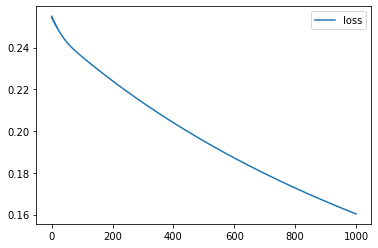

In [98]:
from matplotlib import pyplot as plt
plt.plot(loss)
plt.legend(['loss'])
plt.show()

## Data

In [100]:
import numpy as np
xy = np.loadtxt('data-04-zoo.csv', delimiter=',', dtype=np.float32)

In [101]:
x_train = torch.FloatTensor(xy[:, 0:-1])
y_train = torch.LongTensor(xy[:, [-1]]).squeeze()

In [102]:
print(x_train.shape) # x_train shape
print(len(x_train))  # x_train 길이
print(x_train[:5])   # 첫 다섯 개

torch.Size([101, 16])
101
tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 4., 0., 0., 1.],
        [1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 4., 1., 0., 1.],
        [0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0.],
        [1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 4., 0., 0., 1.],
        [1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 4., 1., 0., 1.]])


In [103]:
print(y_train.shape) # y_train shape
print(len(y_train))  # y_train 길이
print(y_train[:5])   # 첫 다섯 개

torch.Size([101])
101
tensor([0, 0, 3, 0, 0])


In [104]:
nb_classes = 7
y_one_hot = torch.zeros((len(y_train), nb_classes))
y_one_hot = y_one_hot.scatter(1, y_train.unsqueeze(1), 1)

## Training with func.cross_entropy

In [106]:
# 모델 초기화
W = torch.zeros((16, 7), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
# optimizer 설정
optimizer = optim.SGD([W, b], lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # Cost 계산 (2)
    z = x_train.matmul(W) + b # or .mm or @
    cost = func.cross_entropy(z, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 1.945909
Epoch  100/1000 Cost: 0.471836
Epoch  200/1000 Cost: 0.326328
Epoch  300/1000 Cost: 0.257839
Epoch  400/1000 Cost: 0.215762
Epoch  500/1000 Cost: 0.186603
Epoch  600/1000 Cost: 0.164898
Epoch  700/1000 Cost: 0.147955
Epoch  800/1000 Cost: 0.134279
Epoch  900/1000 Cost: 0.122962
Epoch 1000/1000 Cost: 0.113422


## High-level Implementation with nn.Module

In [107]:
class SoftmaxClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(16, 7)
    def forward(self, x):
        return self.linear(x)

In [108]:
model = SoftmaxClassifierModel()

In [110]:

# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    prediction = model(x_train)

    # cost 계산
    cost = func.cross_entropy(prediction, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    # 20번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 2.502898
Epoch  100/1000 Cost: 0.478620
Epoch  200/1000 Cost: 0.325364
Epoch  300/1000 Cost: 0.252136
Epoch  400/1000 Cost: 0.207125
Epoch  500/1000 Cost: 0.176217
Epoch  600/1000 Cost: 0.153539
Epoch  700/1000 Cost: 0.136129
Epoch  800/1000 Cost: 0.122314
Epoch  900/1000 Cost: 0.111072
Epoch 1000/1000 Cost: 0.101739
